# Prerequisites

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np

# DeepSpeed ZeRO-3
import deepspeed
from deepspeed.accelerator import get_accelerator

[2024-05-10 11:42:31,591] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH


/home/it/anaconda3/envs/genety/compiler_compat/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `_dl_audit_symbind_alt@GLIBC_PRIVATE'
/home/it/anaconda3/envs/genety/compiler_compat/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `__nptl_change_stack_perm@GLIBC_PRIVATE'
/home/it/anaconda3/envs/genety/compiler_compat/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `_dl_find_dso_for_object@GLIBC_PRIVATE'
/home/it/anaconda3/envs/genety/compiler_compat/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `_dl_fatal_printf@GLIBC_PRIVATE'
/home/it/anaconda3/envs/genety/compiler_compat/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `_dl_exception_create@GLIBC_PRIVATE'
/home/it/anaconda3/envs/genety/compiler_compat/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `__tunable_get_val@GLIBC_PRIVATE'
/home/it/anaconda3/envs/genety/compiler_compat/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `_dl_audit_preinit@GLIBC_PRI

 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.3
 [WARNING]  using untested triton version (2.3.0), only 1.0.0 is known to be compatible


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


In [4]:
(free_memory, global_memory) = torch.cuda.mem_get_info()
print(f"Free(GB): {free_memory/1024/1024/1024}, Global(GB): {global_memory/1024/1024/1024}, Free(%): {free_memory/global_memory}")

Free(GB): 22.8790283203125, Global(GB): 23.64971923828125, Free(%): 0.9674122593082944


# Load Excel File

In [5]:
import pandas as pd
master_df = pd.read_excel('./DATASETS/Training_Dataset.xlsx')
master_df.head()

,Type,Identity,Text,A2-Unambiguous,A4-Tolerances,A5-Sources specified,E1
0,GSS_CONNECTIVITY,SRD_GSS_FUNC_61,The User and Rights Administration HMI shall p...,1,na,na,1
1,Cobham_ATR,SHLR-ATR2146,The Network Function shall support WiFi 802.11...,1,na,na,1
2,Cobham_ATR,SHLR-ATR797,The PwrCon software shall monitor the output v...,1,na,na,1
3,Cobham_ATR,SHLR-ATR3013,"When prompted, the TETRA Software shall place ...",1,na,na,1
4,Cobham_ATR,SHLR-ATR3198,The TETRA software shall allow users to select...,1,na,na,1


In [6]:
model_df = master_df[['E1','Text']].copy()
model_df.head()

,E1,Text
0,1,The User and Rights Administration HMI shall p...
1,1,The Network Function shall support WiFi 802.11...
2,1,The PwrCon software shall monitor the output v...
3,1,"When prompted, the TETRA Software shall place ..."
4,1,The TETRA software shall allow users to select...


In [7]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3255 entries, 0 to 3254
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   E1      3255 non-null   int64 
 1   Text    3255 non-null   object
dtypes: int64(1), object(1)
memory usage: 51.0+ KB


In [8]:
model_df_label1 = model_df.query('E1 == 1')
len(model_df_label1)

2127

In [9]:
model_df_label0 = model_df.query('E1 == 0')
len(model_df_label0)

1128

In [10]:
model_df = pd.concat([model_df_label1[:1500],model_df_label0])

# Data process and tokenizer

In [11]:
from sklearn.model_selection  import train_test_split
train_df, test_df = train_test_split(model_df, test_size=0.1, shuffle=True)

train_iter = iter(list(train_df.itertuples(index=False, name=None)))
test_iter = iter(list(test_df.itertuples(index=False, name=None)))

In [12]:
len(train_df)

2365

In [13]:
tokenizer = torch.hub.load(
    "huggingface/pytorch-transformers",
    "tokenizer",
    "google/gemma-7b",
)

Using cache found in /home/it/.cache/torch/hub/huggingface_pytorch-transformers_main


In [14]:
tokenizer

GemmaTokenizerFast(name_or_path='google/gemma-7b', vocab_size=256000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<start_of_turn>', '<end_of_turn>']}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<bos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	5: AddedToken("<2mass>", rstrip=False, lstrip=False, single_word

# Dataset iterator

In [15]:
from sklearn.model_selection  import train_test_split
train_df, test_df = train_test_split(model_df, test_size=0.1, shuffle=True)

In [16]:
train_iter = iter(list(train_df.itertuples(index=False, name=None)))
test_iter = iter(list(test_df.itertuples(index=False, name=None)))

In [17]:
next(train_iter)

(0, 'The firewall shall report dropped packet.')

In [18]:
from torch.utils.data import DataLoader

tokenizer.pad_token = tokenizer.eos_token

def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))

    # Create list with indices from tokeniser

    encoded_x = tokenizer(x, padding=True, truncation=True)
    encoded_x.input_ids = torch.tensor(encoded_x.input_ids).to(device)
    encoded_x.attention_mask = torch.tensor(encoded_x.attention_mask).to(device)  
    
    return encoded_x, torch.tensor(y, dtype=torch.long).to(device)

In [19]:
train_iter = iter(list(train_df.itertuples(index=False, name=None)))
first = next(train_iter)
second = next(train_iter)

print(first)
print(second)

collate_batch([first, second])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


(0, 'The firewall shall report dropped packet.')
(0, 'The dog barked its way out of the room.')


({'input_ids': [[1, 1, 1, 2, 651, 72466, 3213, 3484, 15143, 25514, 235265], [2, 651, 5929, 214592, 1277, 1703, 921, 576, 573, 2965, 235265]], 'attention_mask': [[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]},
 tensor([0, 0], device='cuda:0'))

# Define the model

In [20]:
with deepspeed.zero.Init():
    model = torch.hub.load(
        "huggingface/pytorch-transformers",
        "modelForSequenceClassification",
        "google/gemma-7b",
        ignore_mismatched_sizes=True
    )

[2024-05-10 11:43:14,712] [INFO] [comm.py:637:init_distributed] cdb=None
[2024-05-10 11:43:14,713] [INFO] [comm.py:652:init_distributed] Not using the DeepSpeed or dist launchers, attempting to detect MPI environment...
[2024-05-10 11:43:14,798] [INFO] [comm.py:702:mpi_discovery] Discovered MPI settings of world_rank=0, local_rank=0, world_size=1, master_addr=10.1.1.204, master_port=29500
[2024-05-10 11:43:14,799] [INFO] [comm.py:668:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Using cache found in /home/it/.cache/torch/hub/huggingface_pytorch-transformers_main
Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of GemmaForSequenceClassification were not initialized from the model checkpoint at google/gemma-7b and are newly initialized because the shapes did not match:
- model.embed_tokens.weight: found shape torch.Size([256000, 3072]) in the checkpoint and torch.Size([0]) in the model instantiated
- model.layers.0.input_layernorm.weight: found shape torch.Size([3072]) in the checkpoint and torch.Size([0]) in the model instantiated
- model.layers.0.mlp.down_proj.weight: found shape torch.Size([3072, 24576]) in the checkpoint and torch.Size([0]) in the model instantiated
- model.layers.0.mlp.gate_proj.weight: found shape torch.Size([24576, 3072]) in the checkpoint and torch.Size([0]) in the model instantiated
- model.layers.0.mlp.up_proj.weight: found shape torch.Size([24576, 3072]) in the checkpoint and torch.Size([0]) in the model instantiated
- model.layers.0.post_attention_layernorm.weight: found shape torch.Size([3072]) in the checkpoint and torch.Size([0]) in the model instan

[2024-05-10 11:43:17,846] [INFO] [partition_parameters.py:345:__exit__] finished initializing model - num_params = 255, num_elems = 8.54B


In [21]:
with torch.device('meta'):
    model = torch.hub.load(
        "huggingface/pytorch-transformers",
        "modelForSequenceClassification",
        "google/gemma-7b",
        ignore_mismatched_sizes=True
    )

Using cache found in /home/it/.cache/torch/hub/huggingface_pytorch-transformers_main


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of GemmaForSequenceClassification were not initialized from the model checkpoint at google/gemma-7b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
model

GemmaForSequenceClassification(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 3072, padding_idx=0)
    (layers): ModuleList(
      (0-27): 28 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (k_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (v_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=3072, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=3072, out_features=24576, bias=False)
          (up_proj): Linear(in_features=3072, out_features=24576, bias=False)
          (down_proj): Linear(in_features=24576, out_features=3072, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
  

In [22]:
num_class = len(set([label for (label, text) in train_iter]))
num_class

2

In [23]:
for i, parameter in enumerate(model.parameters()):
    parameter.requires_grad = False

In [24]:
model.score = nn.Sequential(
    nn.Linear(in_features=3072, out_features=3072),
    nn.Dropout(),
    nn.Linear(in_features=3072, out_features=2),
)
model.config.pad_token_id = tokenizer.pad_token_id

In [25]:
model

GemmaForSequenceClassification(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 3072, padding_idx=0)
    (layers): ModuleList(
      (0-27): 28 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (k_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (v_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=3072, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=3072, out_features=24576, bias=False)
          (up_proj): Linear(in_features=3072, out_features=24576, bias=False)
          (down_proj): Linear(in_features=24576, out_features=3072, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
  

# Train and eval functions

In [26]:
from datetime import datetime, date
import time

def train(model, dataloader, epoch):
    
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 5
    start_time = time.time()
    total_loss = 0


    for idx, (data, label) in enumerate(dataloader):         
        optimizer.zero_grad()
        
        outputs = model(input_ids=data.input_ids, attention_mask=data.attention_mask)
        predicted_label = outputs.logits
        loss = criterion(predicted_label, label)
        
        # Deepspeed model engine, backward pass 
        model.backward(loss)
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        
        # Deepspeed model engine, optimizer step
        model.step()
        
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        total_loss += loss.item()
        
        # Deepspeed model engine, empty cache
        model.empty_partition_cache()      
        
    return total_acc / total_count, total_loss / total_count
        

def evaluate(model, dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (data, label) in enumerate(dataloader):      
            outputs = model(input_ids=data.input_ids, attention_mask=data.attention_mask)
            predicted_label = outputs.logits
            loss = criterion(predicted_label, label)
            
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)

    return total_acc / total_count, loss.item() / total_count

# Deepspeed

In [27]:
deepspeed_config = {
    "optimizer": {
        "type": "Adam",
        "params": {
            "lr": 0.01,
            "betas": [
                0.8,
                0.999
            ],
            "eps": 1e-8,
            "weight_decay": 3e-7,
        },
    },
    "scheduler": {
        "type": "WarmupLR",
        "params": {
            "warmup_min_lr": 0,
            "warmup_max_lr": 0.01,
            "warmup_num_steps": 1000,
        },
    },
    "train_batch_size": 16,
    # "train_micro_batch_size_per_gpu": "auto",
    # "gradient_accumulation_steps": "auto",
    "fp16": {"enabled": True},
    "zero_optimization": {
        "stage": 3,
        "offload_optimizer": {
            "device": "cpu",
        },
        "offload_param": {
            "device": "cpu",
        },
        "allgather_partitions": True,
        "allgather_bucket_size": 2e8,
        "reduce_scatter": True,
        "reduce_bucket_size": 2e8,
        "overlap_comm": True,
        "load_from_fp32_weights": True,
        "gather_16bit_weights_on_model_save": True,
        "contiguous_gradients": True,
        "stage3_prefetch_bucket_size": 0,
    },
    "gradient_accumulation_steps": 1,
    "train_batch_size": 16,
}

# Initialize DeepSpeed Engine
model_engine, optimizer, _, lr_scheduler = deepspeed.initialize(
    model=model,
    model_parameters=model.parameters(),
    config=deepspeed_config,
)
model_engine

[2024-05-10 11:44:09,049] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed info: version=0.14.2, git-hash=unknown, git-branch=unknown
[2024-05-10 11:44:09,057] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Flops Profiler Enabled: False
[2024-05-10 11:44:10,159] [WARNING] [cpu_adam.py:84:__init__] FP16 params for CPUAdam may not work on AMD CPUs
Installed CUDA version 12.3 does not match the version torch was compiled with 12.1 but since the APIs are compatible, accepting this combination


Using /home/it/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/it/.cache/torch_extensions/py311_cu121/cpu_adam/build.ninja...
/home/it/anaconda3/envs/genety/lib/python3.11/site-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module cpu_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.
Time to load cpu_adam op: 2.196258544921875 seconds


Loading extension module cpu_adam...


[2024-05-10 11:44:12,727] [INFO] [logging.py:96:log_dist] [Rank 0] Using DeepSpeed Optimizer param name adam as basic optimizer
[2024-05-10 11:44:12,728] [INFO] [logging.py:96:log_dist] [Rank 0] Removing param_group that has no 'params' in the basic Optimizer
[2024-05-10 11:44:12,731] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Basic Optimizer = DeepSpeedCPUAdam
[2024-05-10 11:44:12,731] [INFO] [utils.py:56:is_zero_supported_optimizer] Checking ZeRO support for optimizer=DeepSpeedCPUAdam type=<class 'deepspeed.ops.adam.cpu_adam.DeepSpeedCPUAdam'>
[2024-05-10 11:44:12,732] [INFO] [logging.py:96:log_dist] [Rank 0] Creating fp16 ZeRO stage 3 optimizer, MiCS is enabled False, Hierarchical params gather False
[2024-05-10 11:44:12,732] [INFO] [logging.py:96:log_dist] [Rank 0] Creating torch.float16 ZeRO stage 3 optimizer
[2024-05-10 11:44:12,820] [INFO] [utils.py:779:see_memory_usage] Stage 3 initialize beginning
Adam Optimizer #0 is created with AVX512 arithmetic capability.
Config: 

[2024-05-10 11:44:13,654] [INFO] [config.py:1000:print]   curriculum_enabled_legacy .... False
[2024-05-10 11:44:13,654] [INFO] [config.py:1000:print]   curriculum_params_legacy ..... False
[2024-05-10 11:44:13,654] [INFO] [config.py:1000:print]   data_efficiency_config ....... {'enabled': False, 'seed': 1234, 'data_sampling': {'enabled': False, 'num_epochs': 1000, 'num_workers': 0, 'curriculum_learning': {'enabled': False}}, 'data_routing': {'enabled': False, 'random_ltd': {'enabled': False, 'layer_token_lr_schedule': {'enabled': False}}}}
[2024-05-10 11:44:13,654] [INFO] [config.py:1000:print]   data_efficiency_enabled ...... False
[2024-05-10 11:44:13,654] [INFO] [config.py:1000:print]   dataloader_drop_last ......... False
[2024-05-10 11:44:13,654] [INFO] [config.py:1000:print]   disable_allgather ............ False
[2024-05-10 11:44:13,654] [INFO] [config.py:1000:print]   dump_state ................... False
[2024-05-10 11:44:13,655] [INFO] [config.py:1000:print]   dynamic_loss_sc

[2024-05-10 11:44:13,661] [INFO] [config.py:1000:print]   zero_force_ds_cpu_optimizer .. True
[2024-05-10 11:44:13,661] [INFO] [config.py:1000:print]   zero_optimization_stage ...... 3
[2024-05-10 11:44:13,661] [INFO] [config.py:986:print_user_config]   json = {
    "optimizer": {
        "type": "Adam", 
        "params": {
            "lr": 0.01, 
            "betas": [0.8, 0.999], 
            "eps": 1e-08, 
            "weight_decay": 3e-07
        }
    }, 
    "scheduler": {
        "type": "WarmupLR", 
        "params": {
            "warmup_min_lr": 0, 
            "warmup_max_lr": 0.01, 
            "warmup_num_steps": 1000
        }
    }, 
    "train_batch_size": 16, 
    "fp16": {
        "enabled": true
    }, 
    "zero_optimization": {
        "stage": 3, 
        "offload_optimizer": {
            "device": "cpu"
        }, 
        "offload_param": {
            "device": "cpu"
        }, 
        "allgather_partitions": true, 
        "allgather_bucket_size": 2.000000

DeepSpeedEngine(
  (module): GemmaForSequenceClassification(
    (model): GemmaModel(
      (embed_tokens): Embedding(256000, 3072, padding_idx=0)
      (layers): ModuleList(
        (0-27): 28 x GemmaDecoderLayer(
          (self_attn): GemmaSdpaAttention(
            (q_proj): Linear(in_features=3072, out_features=4096, bias=False)
            (k_proj): Linear(in_features=3072, out_features=4096, bias=False)
            (v_proj): Linear(in_features=3072, out_features=4096, bias=False)
            (o_proj): Linear(in_features=4096, out_features=3072, bias=False)
            (rotary_emb): GemmaRotaryEmbedding()
          )
          (mlp): GemmaMLP(
            (gate_proj): Linear(in_features=3072, out_features=24576, bias=False)
            (up_proj): Linear(in_features=3072, out_features=24576, bias=False)
            (down_proj): Linear(in_features=24576, out_features=3072, bias=False)
            (act_fn): PytorchGELUTanh()
          )
          (input_layernorm): GemmaRMSNorm()
  

In [28]:
# device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = get_accelerator().device_name(model_engine.local_rank)
device

'cuda:0'

# Split the dataset and run the model

In [29]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

BATCH_SIZE = 16  # batch size for training

train_iter = iter(list(train_df.itertuples(index=False, name=None)))
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.8)
split_train_, split_valid_ = random_split(
    train_dataset, [num_train, len(train_dataset) - num_train]
)

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

/home/it/anaconda3/envs/genety/lib/python3.11/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [30]:
today = date.today().isoformat()
model_name = "gemma_7b"
checkpoint_path = f"./models/{model_name}"


# Hyperparameters
# EPOCHS = 20  # epoch
# LR = 0.1 # learning rate
    
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
    

def train_with_hist(model, epochs):
    model = model.to(device)
    
    total_accu = None
    best_accu_val = 0.85

    loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid = [], [], [], []
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        accu_train, loss_train = train(model, train_dataloader, epoch)
        accu_val, loss_val = evaluate(model, valid_dataloader)
        
        print({
            "epoch": epoch,
            "loss_train": loss_train,
            "loss_val": loss_val,
            "accuracy_train": accu_train,
            "accuracy_val": accu_val,
        })

        loss_hist_train.append(loss_train)
        loss_hist_valid.append(loss_val)
        accuracy_hist_train.append(accu_train)
        accuracy_hist_valid.append(accu_val)
        
        get_accelerator().empty_cache()
        
        if accu_val > best_accu_val:
            best_accu_val = accu_val
            model_engine.save_16bit_model(f"./models/{model_name}/", f"{today}_{model_name}_checkpoint.pth")
        
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [31]:
import gc

get_accelerator().empty_cache()

gc.collect()
torch.cuda.empty_cache()

In [32]:
(free_memory, global_memory) = torch.cuda.mem_get_info()
print(f"Free(GB): {free_memory/1024/1024/1024}, Global(GB): {global_memory/1024/1024/1024}, Free(%): {free_memory/global_memory}")

Free(GB): 4.8634033203125, Global(GB): 23.64971923828125, Free(%): 0.2056431736593398


In [33]:
hist = train_with_hist(model_engine, epochs=20)

[2024-05-10 11:44:45,122] [INFO] [loss_scaler.py:183:update_scale] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 4294967296, reducing to 2147483648
[2024-05-10 11:44:45,478] [INFO] [loss_scaler.py:183:update_scale] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 2147483648, reducing to 1073741824
[2024-05-10 11:44:45,858] [INFO] [loss_scaler.py:183:update_scale] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 1073741824, reducing to 536870912
[2024-05-10 11:44:46,167] [INFO] [loss_scaler.py:183:update_scale] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 536870912, reducing to 268435456
[2024-05-10 11:44:46,751] [INFO] [loss_scaler.py:183:update_scale] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 268435456, reducing to 134217728
[2024-05-10 11:44:47,149] [INFO] [loss_scaler.py:183:update_scale] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 134217728, reducing to 67108864


[2024-05-10 11:45:46,625] [INFO] [logging.py:96:log_dist] [Rank 0] step=140, skipped=22, lr=[0.006906273357687085], mom=[[0.8, 0.999]]
[2024-05-10 11:45:46,626] [INFO] [timer.py:260:stop] epoch=0/micro_step=140/global_step=140, RunningAvgSamplesPerSec=56.39331484230752, CurrSamplesPerSec=69.24114506219014, MemAllocated=16.83GB, MaxMemAllocated=21.42GB
[2024-05-10 11:45:50,259] [INFO] [logging.py:96:log_dist] [Rank 0] step=150, skipped=22, lr=[0.007024033232159561], mom=[[0.8, 0.999]]
[2024-05-10 11:45:50,260] [INFO] [timer.py:260:stop] epoch=0/micro_step=150/global_step=150, RunningAvgSamplesPerSec=56.69701918322493, CurrSamplesPerSec=56.122352311500634, MemAllocated=17.02GB, MaxMemAllocated=21.42GB
[2024-05-10 11:45:54,644] [INFO] [logging.py:96:log_dist] [Rank 0] step=160, skipped=22, lr=[0.007132930288004122], mom=[[0.8, 0.999]]
[2024-05-10 11:45:54,645] [INFO] [timer.py:260:stop] epoch=0/micro_step=160/global_step=160, RunningAvgSamplesPerSec=56.03399226258286, CurrSamplesPerSec=30

[2024-05-10 11:47:26,777] [INFO] [logging.py:96:log_dist] [Rank 0] step=360, skipped=23, lr=[0.008425433002904463], mom=[[0.8, 0.999]]
[2024-05-10 11:47:26,778] [INFO] [timer.py:260:stop] epoch=0/micro_step=360/global_step=360, RunningAvgSamplesPerSec=56.50917825091995, CurrSamplesPerSec=69.50562651926377, MemAllocated=16.84GB, MaxMemAllocated=21.42GB
[2024-05-10 11:47:30,958] [INFO] [logging.py:96:log_dist] [Rank 0] step=370, skipped=23, lr=[0.00846776491596958], mom=[[0.8, 0.999]]
[2024-05-10 11:47:30,958] [INFO] [timer.py:260:stop] epoch=0/micro_step=370/global_step=370, RunningAvgSamplesPerSec=56.33392499013452, CurrSamplesPerSec=55.27457705296104, MemAllocated=17.02GB, MaxMemAllocated=21.42GB
[2024-05-10 11:47:34,683] [INFO] [logging.py:96:log_dist] [Rank 0] step=380, skipped=23, lr=[0.00850889405370731], mom=[[0.8, 0.999]]
[2024-05-10 11:47:34,684] [INFO] [timer.py:260:stop] epoch=0/micro_step=380/global_step=380, RunningAvgSamplesPerSec=56.412390625281034, CurrSamplesPerSec=45.7

[2024-05-10 11:48:59,883] [INFO] [timer.py:260:stop] epoch=0/micro_step=580/global_step=580, RunningAvgSamplesPerSec=56.25051074713383, CurrSamplesPerSec=57.80652274657557, MemAllocated=16.98GB, MaxMemAllocated=21.42GB
[2024-05-10 11:49:03,217] [INFO] [logging.py:96:log_dist] [Rank 0] step=590, skipped=24, lr=[0.009176054770627572], mom=[[0.8, 0.999]]
[2024-05-10 11:49:03,218] [INFO] [timer.py:260:stop] epoch=0/micro_step=590/global_step=590, RunningAvgSamplesPerSec=56.42504431262859, CurrSamplesPerSec=83.15998934304851, MemAllocated=16.65GB, MaxMemAllocated=21.42GB
{'epoch': 5, 'loss_train': 8.407128493327168, 'loss_val': 1.5412262156448202, 'accuracy_train': 0.888477801268499, 'accuracy_val': 0.7674418604651163}
[2024-05-10 11:49:14,388] [INFO] [logging.py:96:log_dist] [Rank 0] step=600, skipped=24, lr=[0.009201408278077375], mom=[[0.8, 0.999]]
[2024-05-10 11:49:14,388] [INFO] [timer.py:260:stop] epoch=0/micro_step=600/global_step=600, RunningAvgSamplesPerSec=56.5118256975594, CurrSa

[2024-05-10 11:50:43,077] [INFO] [logging.py:96:log_dist] [Rank 0] step=810, skipped=24, lr=[0.009651408486798027], mom=[[0.8, 0.999]]
[2024-05-10 11:50:43,077] [INFO] [timer.py:260:stop] epoch=0/micro_step=810/global_step=810, RunningAvgSamplesPerSec=56.46499709017206, CurrSamplesPerSec=63.26870658511015, MemAllocated=16.94GB, MaxMemAllocated=21.42GB
[2024-05-10 11:50:46,668] [INFO] [logging.py:96:log_dist] [Rank 0] step=820, skipped=24, lr=[0.00966971022579223], mom=[[0.8, 0.999]]
[2024-05-10 11:50:46,669] [INFO] [timer.py:260:stop] epoch=0/micro_step=820/global_step=820, RunningAvgSamplesPerSec=56.53369289998925, CurrSamplesPerSec=40.780168021268516, MemAllocated=17.39GB, MaxMemAllocated=21.42GB
[2024-05-10 11:50:50,357] [INFO] [logging.py:96:log_dist] [Rank 0] step=830, skipped=24, lr=[0.009687783472683635], mom=[[0.8, 0.999]]
[2024-05-10 11:50:50,357] [INFO] [timer.py:260:stop] epoch=0/micro_step=830/global_step=830, RunningAvgSamplesPerSec=56.57429214656596, CurrSamplesPerSec=81.

[2024-05-10 11:52:23,467] [INFO] [timer.py:260:stop] epoch=0/micro_step=1030/global_step=1030, RunningAvgSamplesPerSec=56.41140765386191, CurrSamplesPerSec=79.41642436614302, MemAllocated=16.71GB, MaxMemAllocated=21.42GB
[2024-05-10 11:52:27,673] [INFO] [logging.py:96:log_dist] [Rank 0] step=1040, skipped=24, lr=[0.01], mom=[[0.8, 0.999]]
[2024-05-10 11:52:27,673] [INFO] [timer.py:260:stop] epoch=0/micro_step=1040/global_step=1040, RunningAvgSamplesPerSec=56.34963107195065, CurrSamplesPerSec=72.69992438473221, MemAllocated=16.78GB, MaxMemAllocated=21.42GB
[2024-05-10 11:52:31,153] [INFO] [logging.py:96:log_dist] [Rank 0] step=1050, skipped=24, lr=[0.01], mom=[[0.8, 0.999]]
[2024-05-10 11:52:31,153] [INFO] [timer.py:260:stop] epoch=0/micro_step=1050/global_step=1050, RunningAvgSamplesPerSec=56.41769384367964, CurrSamplesPerSec=57.73053808765968, MemAllocated=16.99GB, MaxMemAllocated=21.42GB
[2024-05-10 11:52:35,126] [INFO] [logging.py:96:log_dist] [Rank 0] step=1060, skipped=24, lr=[0.0

[2024-05-10 11:54:10,674] [INFO] [logging.py:96:log_dist] [Rank 0] step=1270, skipped=24, lr=[0.01], mom=[[0.8, 0.999]]
[2024-05-10 11:54:10,675] [INFO] [timer.py:260:stop] epoch=0/micro_step=1270/global_step=1270, RunningAvgSamplesPerSec=56.4919090676902, CurrSamplesPerSec=73.46763472031249, MemAllocated=16.78GB, MaxMemAllocated=21.42GB
[2024-05-10 11:54:14,916] [INFO] [logging.py:96:log_dist] [Rank 0] step=1280, skipped=24, lr=[0.01], mom=[[0.8, 0.999]]
[2024-05-10 11:54:14,917] [INFO] [timer.py:260:stop] epoch=0/micro_step=1280/global_step=1280, RunningAvgSamplesPerSec=56.43378190080982, CurrSamplesPerSec=52.26258049593831, MemAllocated=17.15GB, MaxMemAllocated=21.42GB
[2024-05-10 11:54:18,878] [INFO] [logging.py:96:log_dist] [Rank 0] step=1290, skipped=24, lr=[0.01], mom=[[0.8, 0.999]]
[2024-05-10 11:54:18,879] [INFO] [timer.py:260:stop] epoch=0/micro_step=1290/global_step=1290, RunningAvgSamplesPerSec=56.41665007919103, CurrSamplesPerSec=46.58461453025865, MemAllocated=17.22GB, Ma

[2024-05-10 11:55:55,608] [INFO] [timer.py:260:stop] epoch=0/micro_step=1500/global_step=1500, RunningAvgSamplesPerSec=56.37900309664275, CurrSamplesPerSec=51.491730952494216, MemAllocated=17.12GB, MaxMemAllocated=21.42GB
[2024-05-10 11:55:59,238] [INFO] [logging.py:96:log_dist] [Rank 0] step=1510, skipped=24, lr=[0.01], mom=[[0.8, 0.999]]
[2024-05-10 11:55:59,239] [INFO] [timer.py:260:stop] epoch=0/micro_step=1510/global_step=1510, RunningAvgSamplesPerSec=56.409777616379195, CurrSamplesPerSec=73.42904911546643, MemAllocated=16.78GB, MaxMemAllocated=21.42GB
[2024-05-10 11:56:03,002] [INFO] [logging.py:96:log_dist] [Rank 0] step=1520, skipped=24, lr=[0.01], mom=[[0.8, 0.999]]
[2024-05-10 11:56:03,003] [INFO] [timer.py:260:stop] epoch=0/micro_step=1520/global_step=1520, RunningAvgSamplesPerSec=56.42186169069265, CurrSamplesPerSec=63.64269206221555, MemAllocated=16.89GB, MaxMemAllocated=21.42GB
[2024-05-10 11:56:07,038] [INFO] [logging.py:96:log_dist] [Rank 0] step=1530, skipped=24, lr=[0

[2024-05-10 11:57:41,190] [INFO] [logging.py:96:log_dist] [Rank 0] step=1730, skipped=25, lr=[0.01], mom=[[0.8, 0.999]]
[2024-05-10 11:57:41,191] [INFO] [timer.py:260:stop] epoch=0/micro_step=1730/global_step=1730, RunningAvgSamplesPerSec=56.18463485731841, CurrSamplesPerSec=52.27560796447286, MemAllocated=17.16GB, MaxMemAllocated=21.42GB
[2024-05-10 11:57:45,431] [INFO] [logging.py:96:log_dist] [Rank 0] step=1740, skipped=25, lr=[0.01], mom=[[0.8, 0.999]]
[2024-05-10 11:57:45,431] [INFO] [timer.py:260:stop] epoch=0/micro_step=1740/global_step=1740, RunningAvgSamplesPerSec=56.14430264624275, CurrSamplesPerSec=39.50022278479224, MemAllocated=17.47GB, MaxMemAllocated=21.42GB
[2024-05-10 11:57:48,891] [INFO] [logging.py:96:log_dist] [Rank 0] step=1750, skipped=25, lr=[0.01], mom=[[0.8, 0.999]]
[2024-05-10 11:57:48,891] [INFO] [timer.py:260:stop] epoch=0/micro_step=1750/global_step=1750, RunningAvgSamplesPerSec=56.18832387487105, CurrSamplesPerSec=80.52767338161955, MemAllocated=16.73GB, M

[2024-05-10 11:59:24,601] [INFO] [timer.py:260:stop] epoch=0/micro_step=1960/global_step=1960, RunningAvgSamplesPerSec=56.26464297791168, CurrSamplesPerSec=57.65737826750006, MemAllocated=16.97GB, MaxMemAllocated=21.42GB
[2024-05-10 11:59:28,741] [INFO] [logging.py:96:log_dist] [Rank 0] step=1970, skipped=25, lr=[0.01], mom=[[0.8, 0.999]]
[2024-05-10 11:59:28,742] [INFO] [timer.py:260:stop] epoch=0/micro_step=1970/global_step=1970, RunningAvgSamplesPerSec=56.23633250183809, CurrSamplesPerSec=69.06108268534946, MemAllocated=16.79GB, MaxMemAllocated=21.42GB
[2024-05-10 11:59:32,476] [INFO] [logging.py:96:log_dist] [Rank 0] step=1980, skipped=25, lr=[0.01], mom=[[0.8, 0.999]]
[2024-05-10 11:59:32,477] [INFO] [timer.py:260:stop] epoch=0/micro_step=1980/global_step=1980, RunningAvgSamplesPerSec=56.2487487854419, CurrSamplesPerSec=73.06457685302024, MemAllocated=16.76GB, MaxMemAllocated=21.42GB
[2024-05-10 11:59:36,162] [INFO] [logging.py:96:log_dist] [Rank 0] step=1990, skipped=25, lr=[0.01

[2024-05-10 12:01:13,518] [INFO] [logging.py:96:log_dist] [Rank 0] step=2200, skipped=25, lr=[0.01], mom=[[0.8, 0.999]]
[2024-05-10 12:01:13,518] [INFO] [timer.py:260:stop] epoch=0/micro_step=2200/global_step=2200, RunningAvgSamplesPerSec=56.18791719055626, CurrSamplesPerSec=81.44170890922572, MemAllocated=16.73GB, MaxMemAllocated=21.42GB
[2024-05-10 12:01:17,021] [INFO] [logging.py:96:log_dist] [Rank 0] step=2210, skipped=25, lr=[0.01], mom=[[0.8, 0.999]]
[2024-05-10 12:01:17,022] [INFO] [timer.py:260:stop] epoch=0/micro_step=2210/global_step=2210, RunningAvgSamplesPerSec=56.22008688886424, CurrSamplesPerSec=55.74293524622913, MemAllocated=17.05GB, MaxMemAllocated=21.42GB
[2024-05-10 12:01:21,424] [INFO] [logging.py:96:log_dist] [Rank 0] step=2220, skipped=25, lr=[0.01], mom=[[0.8, 0.999]]
[2024-05-10 12:01:21,425] [INFO] [timer.py:260:stop] epoch=0/micro_step=2220/global_step=2220, RunningAvgSamplesPerSec=56.17388713959816, CurrSamplesPerSec=64.3253763160518, MemAllocated=16.89GB, Ma

In [34]:
import numpy as np
import matplotlib.pyplot as plt
def plot_learning_curves(hist):
    x_arr = np.arange(len(hist[0])) + 1
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist[0], '-o', label='Train loss')
    ax.plot(x_arr, hist[1], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist[2], '-o', label='Train acc.')
    ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    plt.show()

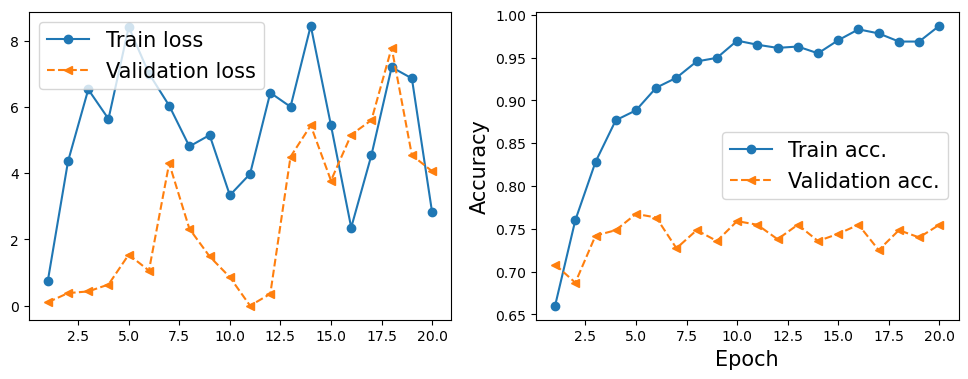

In [35]:
plot_learning_curves(hist)

### Evaluate the model with test dataset

Checking the results of the test dataset…



In [36]:
print("Checking the results of test dataset.")
accu_test, _ = evaluate(model, test_dataloader)
print("test accuracy {:8.3f}".format(accu_test))

Checking the results of test dataset.
test accuracy    0.764


In [37]:
# create confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, dataloader):
    model.eval()
    y_test = np.asarray([])
    y_predict = np.asarray([])

    with torch.no_grad():
        for idx, (data, label) in enumerate(dataloader):
            outputs = model(input_ids=data.input_ids, attention_mask=data.attention_mask)
            predicted_label = outputs.logits
                  
            y_test = np.concatenate((y_test, np.asarray(label.to(device='cpu', dtype=torch.long))), axis=None)
            y_predict = np.concatenate((y_predict, np.asarray((predicted_label.argmax(1).to(device='cpu', dtype=torch.long)))), axis=None)

    cm = confusion_matrix(y_test, y_predict)
    sns.heatmap(cm, annot=True, fmt = "d")
    print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.71      0.78      0.74       113
         1.0       0.82      0.76      0.79       150

    accuracy                           0.77       263
   macro avg       0.76      0.77      0.77       263
weighted avg       0.77      0.77      0.77       263



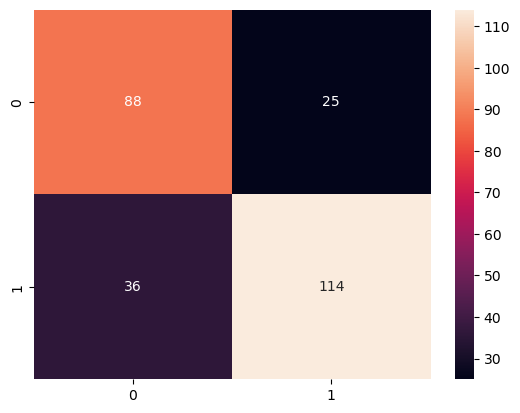

In [38]:
plot_confusion_matrix(model, test_dataloader)

In [39]:
def predict(text):
    with torch.no_grad():
        encoded_text = tokenizer(text)
        encoded_text.input_ids = torch.tensor(encoded_text.input_ids).to(device).unsqueeze(0)
        encoded_text.attention_mask = torch.tensor(encoded_text.attention_mask).to(device).unsqueeze(0)

        outputs = model(input_ids=encoded_text.input_ids, attention_mask=encoded_text.attention_mask)
        predicted_label = outputs.logits
        return predicted_label.argmax(1).item()

In [40]:
ex_text_str = 'The ePump Software shall define Fault ID 1 as follows:'

print("This is a %s" % predict(ex_text_str))

This is a 0


In [41]:
pred_text = "The IO Service shall select the XLR-PW DEV_INFO_DATA file if HPP_XLR_WIRING is grounded (logical 1) and bits AC_TYPE_BIT1 - AC_TYPE_BIT6 do not indicate a CFM engine configuration. NOTE: HPP_XLR_WIRING and bits AC_TYPE_BIT[1-6] are discrete inputs which are received on constant pins between hardware configurations. See 282100-ICD-x for more details."
predict(pred_text)

1

In [42]:
pred_text = "I shall like waffles"
predict(pred_text)

0

In [43]:
pred_text = "Bumblebe is red"
predict(pred_text)

0

In [44]:
pred_text = "Bumblebee is red"
predict(pred_text)

0

In [45]:
from datetime import datetime, date
model_name = "gemma_7b"
today = date.today().isoformat()

In [47]:
model_engine.save_16bit_model(f"./models/{model_name}/", f"{today}_{model_name}_2.pth")

[2024-05-10 12:05:52,039] [INFO] [logging.py:96:log_dist] [Rank 0] [Torch] Checkpoint global_step2380 is about to be saved!
[2024-05-10 12:05:52,039] [INFO] [engine.py:3596:save_16bit_model] Saving model weights to ./models/gemma_7b/2024-05-10_gemma_7b_2.pth, tag: global_step2380
[2024-05-10 12:05:52,040] [INFO] [torch_checkpoint_engine.py:21:save] [Torch] Saving ./models/gemma_7b/2024-05-10_gemma_7b_2.pth...
[2024-05-10 12:06:05,869] [INFO] [torch_checkpoint_engine.py:23:save] [Torch] Saved ./models/gemma_7b/2024-05-10_gemma_7b_2.pth.
[2024-05-10 12:06:05,869] [INFO] [torch_checkpoint_engine.py:33:commit] [Torch] Checkpoint global_step2380 is ready now!


True

In [31]:
loaded_state_dict = torch.load(f"/home/it/environments/Genety/models/{model_name}/{today}_{model_name}.pth", mmap=True)
loaded_state_dict

OrderedDict([('model.embed_tokens.weight',
              tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
                      [ 0.0155, -0.0138,  0.0460,  ..., -0.0035,  0.0096,  0.0147],
                      [-0.0128,  0.0186,  0.0124,  ...,  0.0279, -0.0185,  0.0166],
                      ...,
                      [-0.0046, -0.0186, -0.0093,  ..., -0.0291,  0.0085, -0.0129],
                      [-0.0070,  0.0447, -0.0192,  ...,  0.0064,  0.0377,  0.0028],
                      [ 0.0225, -0.0199,  0.0173,  ...,  0.0483, -0.0099,  0.0029]],
                     dtype=torch.float16)),
             ('model.layers.0.self_attn.q_proj.weight',
              tensor([[ 1.1101e-02, -3.9337e-02, -6.6643e-03,  ..., -1.4275e-02,
                        1.4923e-02,  1.0880e-02],
                      [-1.1034e-03,  3.7048e-02, -9.9716e-03,  ...,  1.1520e-02,
                       -3.3325e-02, -1.9180e-02],
                      [-1.4656e-02, -2.8954e-03,  1.7107e-04,  

In [35]:
model = model.to(device)

In [33]:
device

device(type='cuda')

In [34]:
model.load_state_dict(loaded_state_dict, assign=True, strict=False)

<All keys matched successfully>

In [36]:
torch.save(model, f"./models/{model_name}/{today}_{model_name}.pt")